In [3]:
# Install required packages from within Jupyter
!pip install --upgrade pandas numpy matplotlib seaborn scikit-learn xgboost

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [5]:
# Step 2: Load data
df = pd.read_csv("../data/walmart_sales.csv")
print(df.head())
print(df.info())

   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   i

In [6]:
# Step 3: Data Preprocessing

# Convert Date column to datetime (DD-MM-YYYY format)
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y", errors="coerce")

# Check for any invalid dates
print("Number of invalid dates:", df["Date"].isna().sum())

# Drop rows with invalid dates if any
df = df.dropna(subset=["Date"])

# Sort by Date
df = df.sort_values("Date")

# Aggregate weekly sales (sum across all stores/departments per week)
weekly_sales = df.groupby("Date")["Weekly_Sales"].sum().reset_index()
print(weekly_sales.head())


Number of invalid dates: 0
        Date  Weekly_Sales
0 2010-02-05   49750740.50
1 2010-02-12   48336677.63
2 2010-02-19   48276993.78
3 2010-02-26   43968571.13
4 2010-03-05   46871470.30


In [7]:
# Step 4: Feature Engineering

# Extract year, month, week from date
weekly_sales["Year"] = weekly_sales["Date"].dt.year
weekly_sales["Month"] = weekly_sales["Date"].dt.month
weekly_sales["Week"] = weekly_sales["Date"].dt.isocalendar().week

# Create lag features (previous week sales)
weekly_sales["Lag_1"] = weekly_sales["Weekly_Sales"].shift(1)
weekly_sales["Lag_2"] = weekly_sales["Weekly_Sales"].shift(2)

# Rolling mean for last 4 weeks
weekly_sales["Rolling_mean_4"] = weekly_sales["Weekly_Sales"].shift(1).rolling(4).mean()

# Drop rows with NaN created by lag/rolling features
weekly_sales.dropna(inplace=True)

# Check the final feature set
print(weekly_sales.head())


        Date  Weekly_Sales  Year  Month  Week        Lag_1        Lag_2  \
4 2010-03-05   46871470.30  2010      3     9  43968571.13  48276993.78   
5 2010-03-12   45925396.51  2010      3    10  46871470.30  43968571.13   
6 2010-03-19   44988974.64  2010      3    11  45925396.51  46871470.30   
7 2010-03-26   44133961.05  2010      3    12  44988974.64  45925396.51   
8 2010-04-02   50423831.26  2010      4    13  44133961.05  44988974.64   

   Rolling_mean_4  
4    4.758325e+07  
5    4.686343e+07  
6    4.626061e+07  
7    4.543860e+07  
8    4.547995e+07  


In [8]:
# Step 5: Train-test split
X = weekly_sales[["Year","Month","Week","Lag_1","Lag_2","Rolling_mean_4"]]
y = weekly_sales["Weekly_Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (111, 6)
Test shape: (28, 6)


In [9]:
# Step 6: Train model with XGBoost + GridSearch
model = XGBRegressor(objective="reg:squarederror", random_state=42)

params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1]
}

grid = GridSearchCV(model, params, scoring="neg_mean_absolute_error", cv=3, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}


In [10]:
# Step 7: Predictions
y_pred = best_model.predict(X_test)


In [11]:
# Step 8: Evaluation
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAPE:", round(mape*100, 2), "%")
print("RMSE:", round(rmse, 2))


MAPE: 2.91 %
RMSE: 1661674.44


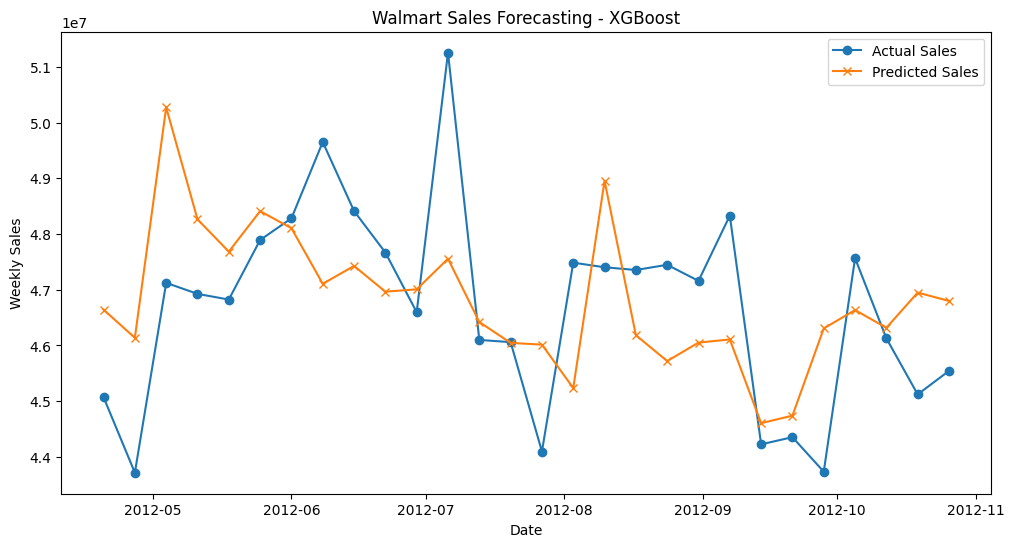

In [12]:
# Step 9: Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(weekly_sales["Date"][-len(y_test):], y_test, label="Actual Sales", marker="o")
plt.plot(weekly_sales["Date"][-len(y_test):], y_pred, label="Predicted Sales", marker="x")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Walmart Sales Forecasting - XGBoost")
plt.legend()
plt.show()
